In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Auction Algorithm

In [228]:
def _random_er_bipartite_graph(n, m, p = 0.25, weighted = False, directed=False, low = 0.0, high = 1.0):
        """Random bipartite graph-based flow network."""
        mat = np.random.binomial(1, p, size = (n, m))
        
        if weighted:
            weights = np.random.uniform(low = low, high = high, size = (n, m))
            mat = np.multiply(mat, weights)
            
        return np.array(mat)

In [226]:
def auction_algorithm(A, verbose=False):
    n, m = A.shape
    values = np.copy(A)
    eps = 1 / (n + 1)
    
    unassigned = set(np.arange(n))
    owner = np.zeros(m) - 1
    alg = 0
    trajectory = [alg]
    
    def _compute_bids(values, unassigned):
        items = np.argmax(values, axis=1)
        v = np.max(values, axis=1)
        B = np.copy(values)
        B[np.arange(values.shape[0]), items] = 0
        w = np.max(B, axis=1)
        bids = v - w + eps
        bid_mat = np.zeros((n, m))
        bid_mat[list(unassigned), items] = bids
        return bid_mat
    
    while unassigned:
        if np.all(values[list(unassigned)] <= 0):
            break
        bid_matrix = _compute_bids(values[list(unassigned), :], unassigned)
        assignments = np.argmax(bid_matrix, axis=0)
        increments = np.max(bid_matrix, axis=0)
        
        if verbose:
            print(f"Unassigned: {list(unassigned)}")
            print(f"Bid matrix:\n {bid_matrix}")
            print(f"Assignments: {assignments}")
            
        for i in range(m):
            candidate = assignments[i]
            if candidate in unassigned and bid_matrix[candidate, i] != 0:
                prev_owner = int(owner[i])
                if prev_owner != -1:
                    unassigned.add(prev_owner)
                    alg -= A[prev_owner, i]
                    
                owner[i] = candidate
                unassigned.remove(candidate)
                values[:, i] -= increments[i]
                alg += A[candidate, i]
        trajectory.append(alg)
        
    return owner, trajectory


In [298]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

def plot_trajectories(trajectories, xmin, xmax, ymin, ymax):
    fig = plt.figure(figsize=(10,8))
    y, error = tolerant_mean(trajectories)
    plt.plot(np.arange(len(y)), y, color='green')
    plt.fill_between(np.arange(len(y)), y-error, y+error,
        alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    plt.xlim(xmin-0.5,xmax+0.5)
    plt.ylim(ymin, ymax)
    plt.hlines(y=1, xmin=xmin, xmax=xmax, color='r', linestyle='--', label='OPT')
    plt.legend()
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xticks(np.arange(xmax + 1))
    plt.show()


## Message passing round
Each buyer sents a message with a bid to their most favored good:
<div>
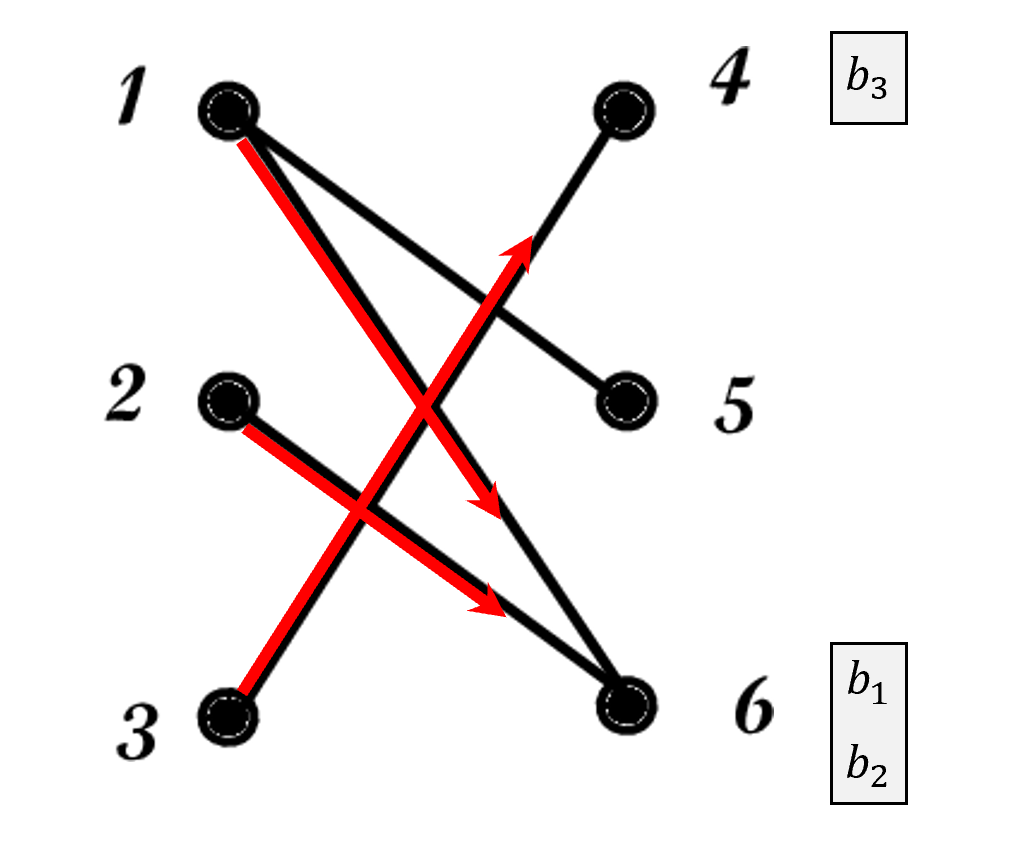
</div>


### Experiment 1: varying p

In [358]:
num_trials = 250
experiment_specs = [(64, 64, 0.25), (64, 64, 0.5), (64, 64, 0.75), (64, 64, 1)]
avg_trajectories = []

for spec in experiment_specs:
    trajectories = []
    lb = 0
    ub = 0
    for i in range(num_trials):
        vals = _random_er_bipartite_graph(*spec, weighted=True)
        row_ind, col_ind = linear_sum_assignment(-vals)
        opt = vals[row_ind, col_ind].sum()
        _, trajectory = auction_algorithm(vals, verbose=False)
        trajectories.append(np.array(trajectory) / opt)
        lb += (opt - 1) / num_trials
        ub += (opt) / num_trials
    print(f"ALG bound {(spec)}: [{round(lb/ub, 4)}, {1}]")

    avg_trajectories.append(tolerant_mean(trajectories)[0].data)

ALG bound (64, 64, 0.25): [0.9827, 1]
ALG bound (64, 64, 0.5): [0.9836, 1]
ALG bound (64, 64, 0.75): [0.9838, 1]


C:\Users\awiku\Anaconda3\lib\site-packages\numpy\ma\core.py:4283: RuntimeWarning: invalid value encountered in multiply
  getdata(other)))


ALG bound (64, 64, 1): [0.984, 1]


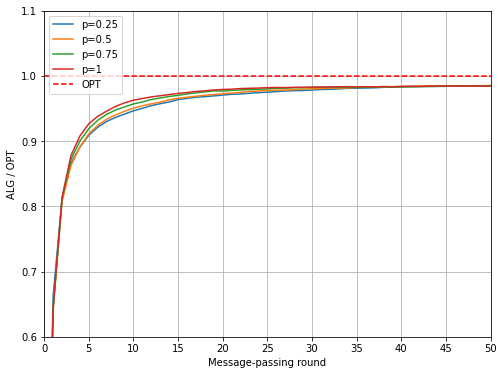

In [359]:
fig = plt.figure(figsize=(8,6))
for i in range(len(avg_trajectories)):
    plt.plot(range(len(avg_trajectories[i])), avg_trajectories[i], label=f"p={experiment_specs[i][2]}")
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xlim(1, 50)
    plt.ylim(0.6, 1.1)
plt.hlines(y=1, xmin=0, xmax=50, color='r', linestyle='--', label='OPT')
plt.xticks(np.arange(0, 51, 5))
plt.grid()
plt.legend()
plt.show()

### Experiment 2: Varying n

In [354]:
num_trials = 250
experiment_specs = [(48, 64, 1), (64, 64, 1), (80, 64, 1)]
avg_trajectories = []

for spec in experiment_specs:
    trajectories = []
    lb = 0
    ub = 0
    for i in range(num_trials):
        vals = _random_er_bipartite_graph(*spec, weighted=True)
        row_ind, col_ind = linear_sum_assignment(-vals)
        opt = vals[row_ind, col_ind].sum()
        _, trajectory = auction_algorithm(vals, verbose=False)
        trajectories.append(np.array(trajectory) / opt)
        lb += (opt - 1) / num_trials
        ub += (opt) / num_trials
    print(f"ALG bound {(spec)}: [{round(lb/ub, 4)}, {1}]")

    avg_trajectories.append(tolerant_mean(trajectories)[0].data)

ALG bound (48, 64, 1): [0.9787, 1]
ALG bound (64, 64, 1): [0.984, 1]
ALG bound (80, 64, 1): [0.9841, 1]


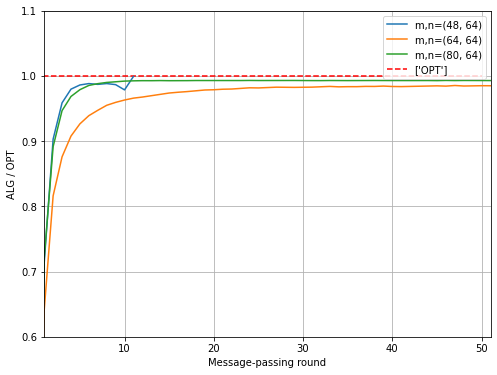

In [355]:
fig = plt.figure(figsize=(8,6))
for i in range(len(avg_trajectories)):
    plt.plot(range(len(avg_trajectories[i])), avg_trajectories[i], label=f"m,n={experiment_specs[i][0], experiment_specs[i][1]}")
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xlim(1, 51, 5)
    plt.ylim(0.6, 1.1)
plt.hlines(y=[1], xmin=0, xmax=50, color=['r'], linestyle='--', label=['OPT'])
plt.legend()
plt.grid()
plt.show()

## Min-sum Algorithm